In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
import torch.nn.functional as F
import tqdm

In [216]:
SCALER = 'NONE'
# SCALER = 'MINMAX'
LAST_N = -15

In [217]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [218]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5322,2024-04-24,5071.629883,1370.479980,2324.500000,2675.750000,2628.620117
5323,2024-04-25,5048.419922,1376.969971,2329.800049,2628.620117,2656.330078
5324,2024-04-26,5099.959961,1371.699951,2334.800049,2656.330078,2705.139893
5325,2024-04-29,5116.169922,1377.089966,2345.800049,2656.330078,2705.139893
5326,2024-04-30,5116.169922,1377.089966,2345.800049,2705.139893,2705.139893


In [219]:
# df = df.drop('Date', axis=1)
# df_1 = df.iloc[:LAST_N, :].copy()
df_1 = df.drop('Date', axis=1)
print(df_1.tail())
train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_1.columns.values
print(col_names)

              S&P     currency         gold        kospi  kospi_shift
5322  5071.629883  1370.479980  2324.500000  2675.750000  2628.620117
5323  5048.419922  1376.969971  2329.800049  2628.620117  2656.330078
5324  5099.959961  1371.699951  2334.800049  2656.330078  2705.139893
5325  5116.169922  1377.089966  2345.800049  2656.330078  2705.139893
5326  5116.169922  1377.089966  2345.800049  2705.139893  2705.139893
['S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [220]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[:-1]:
    scale_params[i] = [train_x[i].mean(), train_x[i].var(), train_x[i].max(), train_x[i].min()]
scale_params

,S&P,currency,gold,kospi
mean,2.187584e+03,1129.655425,1250.717563,1942.743175
var,1.294197e+06,12506.641795,216692.041377,289745.259479
max,5.254350e+03,1571.400024,2398.399902,3305.209961
min,6.825500e+02,886.679993,374.799988,719.590027


In [221]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
elif SCALER == 'NONE':
    for i in col_names[:-1]:
        train_data[i] = train_x[i]
        test_data[i] = test_x[i]

test_data.tail()

,S&P,currency,gold,kospi
1120,1276.599976,987.989990,1001.400024,1574.439941
4308,3112.350098,1215.819946,1718.900024,2151.179932
3983,2748.929932,1127.000000,1283.800049,2165.790039
4770,4173.109863,1236.890015,1959.599976,2645.649902
1246,1224.510010,1101.599976,787.099976,1454.500000


In [222]:
class Stockdataset(Dataset):
    def __init__(self, data, y_value):
        self.len = data.shape[0]
        self.feature_size = data.shape[1]
        # print(self.len, self.feature_size)
        x = np.zeros((self.len, self.feature_size))
        y = np.zeros(self.len)
        # print(x.shape)
        for i in range(self.len):
            # print(i)
            x[i, :] = data.iloc[i, :]
            y[i] = y_value.iloc[i]
        self.X = x
        self.Y = y
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [223]:
BATCH_SIZE = 64
train_dataset = Stockdataset(train_data, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = Stockdataset(test_data, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(next(iter(test_dataset)))

(array([2783.02001953, 1187.57995605, 1280.59997559, 2023.31994629]), 2038.800048828125)


In [224]:
test_data.shape, test_y.shape

((533, 4), (533,))

### Make a MLP model

In [225]:
class StockMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 30)
        self.fc2 = nn.Linear(30, 40)
        self.fc3 = nn.Linear(40, 50)
        self.fc4 = nn.Linear(50, 40)
        self.fc5 = nn.Linear(40, 30)
        self.fc6 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        return x

In [226]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StockMLP().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Train

In [227]:
loss_result = pd.DataFrame(columns=['epochs', 'loss'])
epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for _, data in enumerate(train_dataloader):
        # print(data[0])
        # print(data[1])
        inputs = data[0].to(device).float()
        outputs = data[1].to(device).float()
        model.training()
        # print(inputs)

        optimizer.zero_grad()
        result = model(inputs)
        loss = loss_fn(result, outputs.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'epoch #{epoch} loss: {running_loss:.6f}')
    loss_result.loc[epoch] = [epoch, running_loss]

epoch #0 loss: 296343949.500000
epoch #1 loss: 243088944.250000
epoch #2 loss: 79568622.968750
epoch #3 loss: 31612090.562500
epoch #4 loss: 27927483.734375
epoch #5 loss: 25688136.250000
epoch #6 loss: 24180877.281250
epoch #7 loss: 22813994.078125
epoch #8 loss: 22016763.046875
epoch #9 loss: 20785413.843750
epoch #10 loss: 19823629.968750
epoch #11 loss: 19894496.250000
epoch #12 loss: 19057752.820312
epoch #13 loss: 17899927.937500
epoch #14 loss: 18294935.578125
epoch #15 loss: 17326566.453125
epoch #16 loss: 16467391.906250
epoch #17 loss: 16821283.390625
epoch #18 loss: 16275824.312500
epoch #19 loss: 15799204.109375
epoch #20 loss: 16310773.984375
epoch #21 loss: 15648422.078125
epoch #22 loss: 15204081.609375
epoch #23 loss: 15425576.320312
epoch #24 loss: 15953166.046875
epoch #25 loss: 14616232.343750
epoch #26 loss: 14713503.171875
epoch #27 loss: 14480354.601562
epoch #28 loss: 14887587.648438
epoch #29 loss: 15016206.890625
epoch #30 loss: 14454683.218750
epoch #31 loss: 

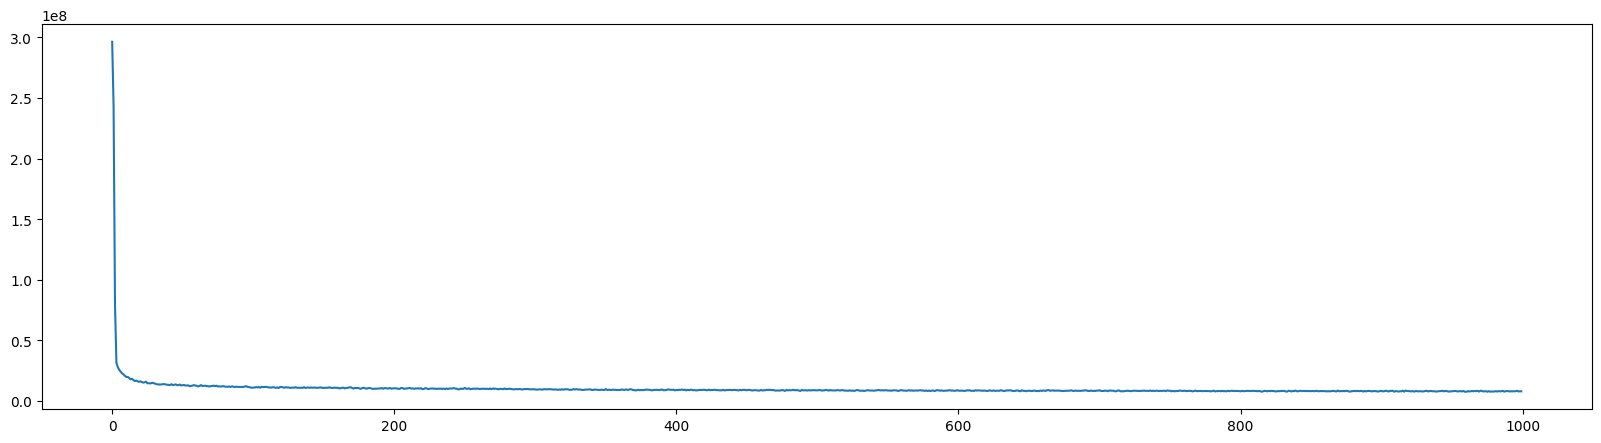

In [228]:
plt.figure(figsize=(20, 5))
plt.plot(loss_result['epochs'], loss_result['loss'])
plt.show()

### Test

In [245]:
test_result = pd.DataFrame(columns=['pred', 'real'])
num = 0
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            test_result.loc[num] = [pred.detach().cpu().numpy()[i][0], outputs.numpy()[i]]
            num += 1

In [246]:
test_result

,pred,real
0,3210.766602,2317.139893
1,2214.310059,1994.959961
2,1605.993042,2113.719971
3,1974.067139,2580.709961
4,1695.065186,2091.870117
...,...,...
528,1500.875732,1787.489990
529,3194.229492,2706.959961
530,1523.286133,1615.619995
531,2169.771973,1682.770020


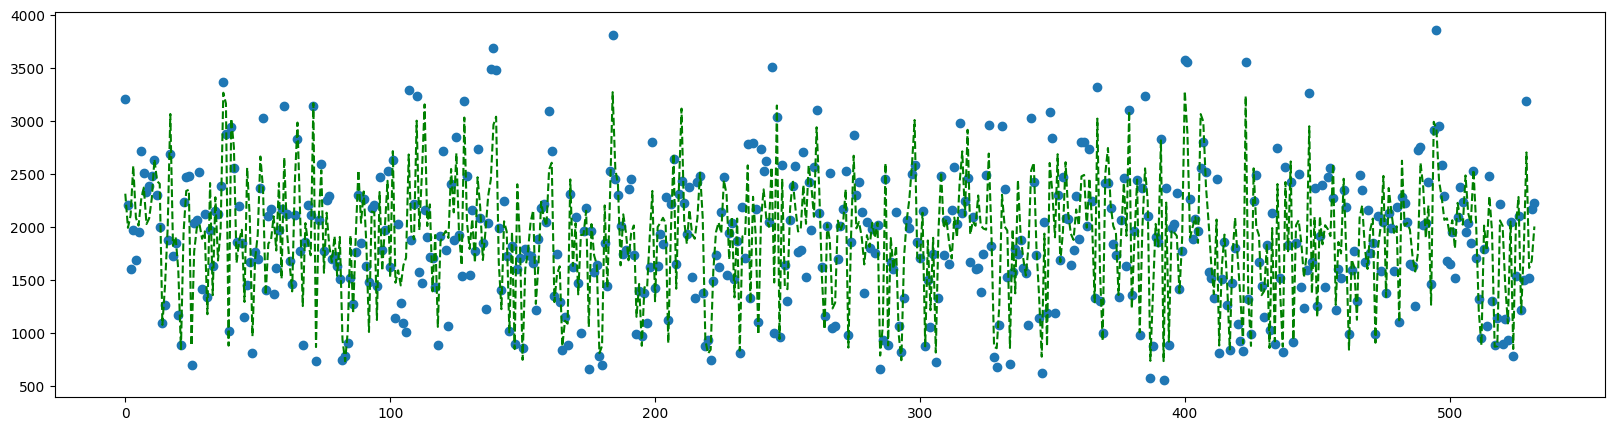

In [254]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

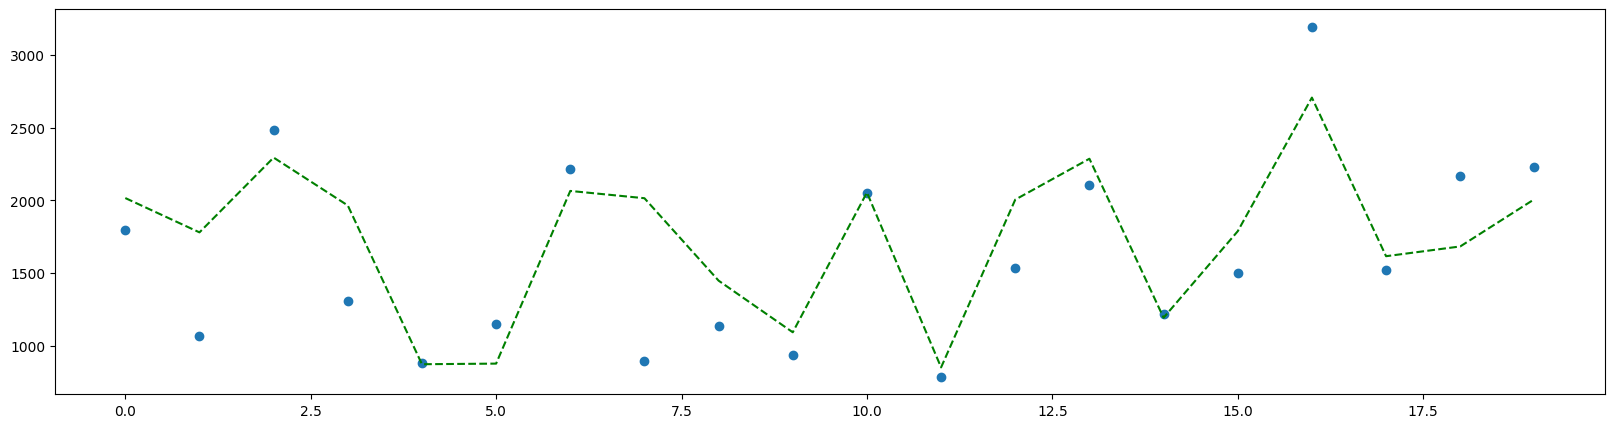

In [256]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 0], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 1], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.show()

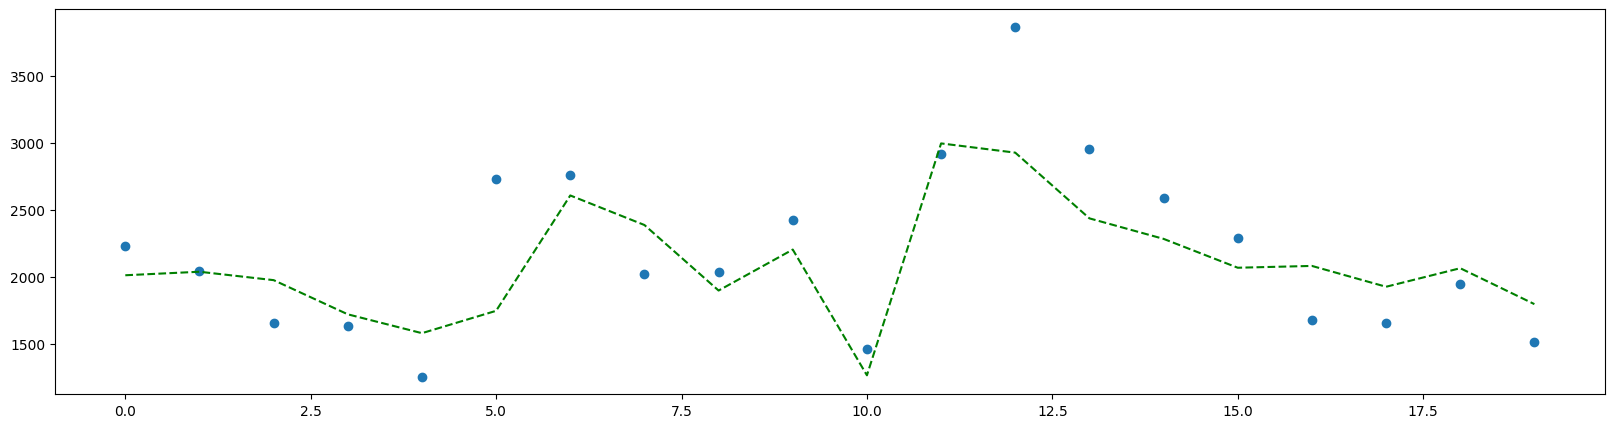

In [257]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 0], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 1], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.show()